In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
from scipy.linalg import block_diag

In [3]:
data = "../data/robot_data.csv"


In [4]:
df = pd.read_csv(data,header=None, names=['wheel_l','wheel_r','beta_l','beta_r','alpha', 'i', 'j'])

In [5]:
df

,wheel_l,wheel_r,beta_l,beta_r,alpha,i,j
0,3.165405,6.680110,-0.065305,0.056662,-0.010141,1.0,4.0
1,22.448008,24.278503,1.214448,1.371093,0.000000,2.0,5.0
2,15.413212,18.239408,0.405794,0.647352,0.000000,7.0,8.0
3,18.935149,21.107028,1.308350,1.494085,0.000000,9.0,6.0
4,10.081041,12.209634,0.477302,0.659099,0.000000,8.0,4.0
...,...,...,...,...,...,...,...
1825,4.651274,5.792498,-0.006649,0.005046,-0.005186,8.0,4.0
1826,6.374602,4.660173,0.015496,-0.004521,0.010365,7.0,3.0
1827,12.451066,13.853606,-0.006929,0.007315,-0.006267,4.0,1.0
1828,2.286067,4.403998,-0.015795,0.009394,-0.012138,1.0,4.0


In [29]:
i_filter = 9
j_filter = 6

In [31]:
filtered = df[(df.i == i_filter) & (df.j == j_filter)]
filtered

,wheel_l,wheel_r,beta_l,beta_r,alpha,i,j
3,18.935149,21.107028,1.308350,1.494085,0.000000,9.0,6.0
8,13.387768,17.046068,0.528214,0.841082,0.000000,9.0,6.0
13,-4.212835,0.895737,-0.843693,-0.513561,-0.056067,9.0,6.0
18,-6.906070,-0.413558,-0.771998,-0.312418,-0.190070,9.0,6.0
23,5.759111,12.802012,0.364718,0.697934,-0.124728,9.0,6.0
...,...,...,...,...,...,...,...
1770,3.965082,5.579391,-0.011517,0.007384,-0.013355,9.0,6.0
1775,3.386378,5.606496,-0.015526,0.011206,-0.025319,9.0,6.0
1780,2.938221,5.782317,-0.017242,0.016442,-0.043238,9.0,6.0
1785,2.778673,6.090135,-0.015750,0.022120,-0.061747,9.0,6.0


In [32]:
x = filtered[['wheel_l','wheel_r']].values
y = filtered[['beta_l','beta_r','alpha']].values

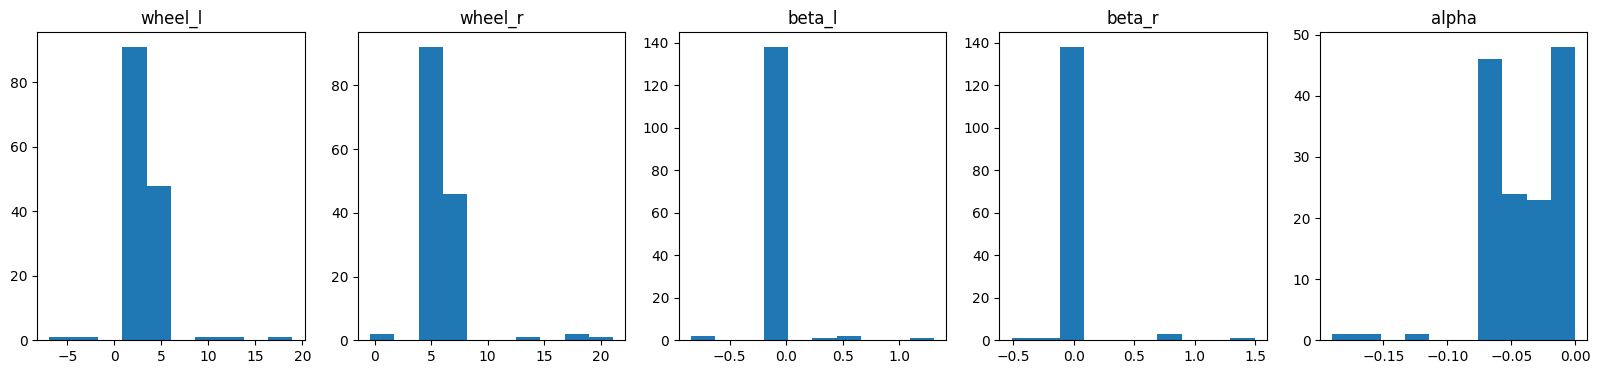

In [33]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
ax[0].hist(x[..., 0])
ax[0].set_title('wheel_l')
ax[1].hist(x[..., 1])
ax[1].set_title('wheel_r')
# %% plot histogram to see if output distribution is well behaved, to see if it is neeeded a scaling
ax[2].hist(y[..., 0])
ax[2].set_title('beta_l')
ax[3].hist(y[..., 1])
ax[3].set_title('beta_r')
ax[4].hist(y[..., 2])
ax[4].set_title('alpha')
plt.show()

In [34]:
# Example data
omega_l = filtered.wheel_l.values
omega_r = filtered.wheel_r.values
beta_l = filtered.beta_l.values
beta_r = filtered.beta_r.values
alpha = filtered.alpha.values
Y = np.column_stack((beta_l, beta_r, alpha))

# Initial OLS regression to get residuals
X = np.column_stack((np.ones(len(omega_l)), omega_l, omega_r))
theta_hat_ols = np.linalg.inv(X.T @ X) @ (X.T @ Y)
y_hat_ols = X @ theta_hat_ols
residuals_ols = Y - y_hat_ols

# Estimate weights as the inverse of the squared residuals
weights_l = 1 / (residuals_ols[:, 0] ** 2)
weights_r = 1 / (residuals_ols[:, 1] ** 2)
weights_alpha = 1 / (residuals_ols[:, 2] ** 2)

# Create individual diagonal weight matrices for each output
W_l = np.diag(weights_l)
W_r = np.diag(weights_r)
W_alpha = np.diag(weights_alpha)

# Combine these into a block diagonal matrix
W = block_diag(W_l, W_r, W_alpha)

# Expand X to match the block diagonal structure
X_expanded = np.kron(np.eye(3), X)  # Kronecker product to create the expanded X matrix

# Now compute WLS using the expanded X and Y
XTWX_inv = np.linalg.inv(X_expanded.T @ W @ X_expanded)
XTWy = X_expanded.T @ W @ Y.flatten(order='F')
theta_hat_wls_flat = XTWX_inv @ XTWy

# Reshape the result back to the original coefficient shape
theta_hat_wls = theta_hat_wls_flat.reshape(3, -1).T

# Estimated coefficients from WLS
theta_0, theta_1, theta_2 = theta_hat_wls
print("WLS Estimated coefficients:", theta_hat_wls)


WLS Estimated coefficients: [[-0.29617125 -0.27589369  0.02232979]
 [ 0.02789009  0.00336723  0.0287048 ]
 [ 0.03142937  0.0475848  -0.02683523]]


In [35]:
X.shape

(144, 3)

In [52]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle("Residuals")
ax[0].scatter(np.arange(len(residuals_ols[...,0])), residuals_ols[...,0], color="green")
ax[0].axhline(0, linestyle='--', color="black")
ax[0].set_title("beta_l")
ax[1].scatter(np.arange(len(residuals_ols[...,1])), residuals_ols[...,1], color="orange")
ax[1].axhline(0, linestyle='--', color="black")
ax[1].set_title("beta_r")
ax[2].scatter(np.arange(len(residuals_ols[...,2])), residuals_ols[...,2], color="purple")
ax[2].axhline(0, linestyle='--', color="black")
ax[2].set_title("alpha")
plt.show()

In [37]:
y_hat = X @ theta_hat_wls

In [38]:
residuals_wls = Y - y_hat

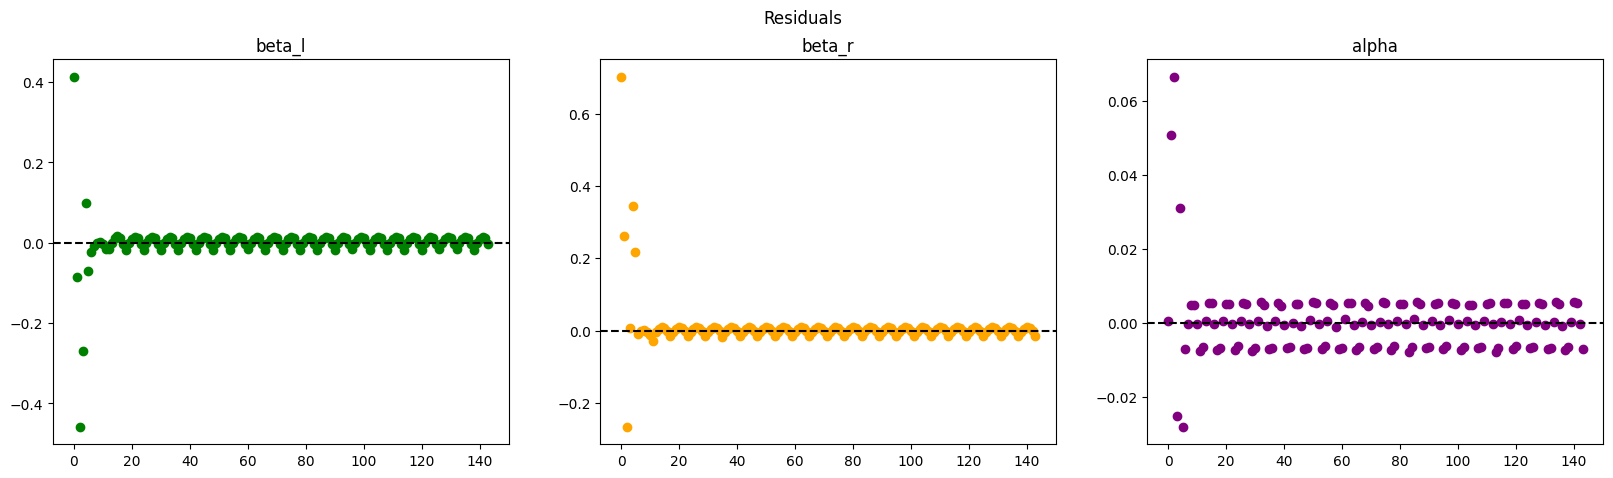

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle("Residuals")
ax[0].scatter(np.arange(len(residuals_wls[...,0])), residuals_wls[...,0], color="green")
ax[0].axhline(0, linestyle='--', color="black")
ax[0].set_title("beta_l")
ax[1].scatter(np.arange(len(residuals_wls[...,1])), residuals_wls[...,1], color="orange")
ax[1].axhline(0, linestyle='--', color="black")
ax[1].set_title("beta_r")
ax[2].scatter(np.arange(len(residuals_wls[...,2])), residuals_wls[...,2], color="purple")
ax[2].axhline(0, linestyle='--', color="black")
ax[2].set_title("alpha")
plt.show()

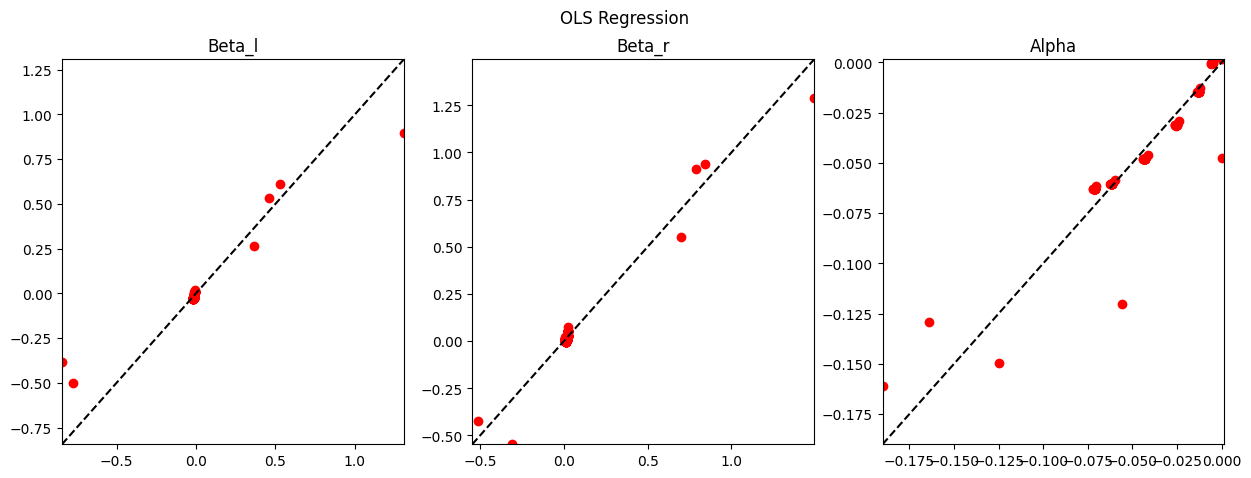

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("OLS Regression")
# fig.suptitle('Horizontally stacked subplots')
# Beta_l
y_min = min(Y[...,0].min(),y_hat_ols[...,0].min())
y_max = max(Y[...,0].max(),y_hat_ols[...,0].max())
ax[0].set_title("Beta_l")
ax[0].set_xlim(y_min,y_max)
ax[0].set_ylim(y_min,y_max)
ax[0].scatter(Y[...,0],y_hat[...,0], color="red")
ax[0].plot([y_min,y_max],[y_min,y_max], "--", color='black')
# Beta_r
y_min = min(Y[...,1].min(),y_hat_ols[...,1].min())
y_max = max(Y[...,1].max(),y_hat_ols[...,1].max())
ax[1].set_title("Beta_r")
ax[1].set_xlim(y_min,y_max)
ax[1].set_ylim(y_min,y_max)
ax[1].scatter(Y[...,1],y_hat_ols[...,1], color="red")
ax[1].plot([y_min,y_max],[y_min,y_max], "--", color='black')
# Alpha
y_min = min(Y[...,2].min(),y_hat_ols[...,2].min())
y_max = max(Y[...,2].max(),y_hat_ols[...,2].max())
ax[2].set_title("Alpha")
ax[2].set_xlim(y_min,y_max)
ax[2].set_ylim(y_min,y_max)
ax[2].scatter(Y[...,2],y_hat_ols[...,2], color="red")
ax[2].plot([y_min,y_max],[y_min,y_max], "--", color='black')
plt.show()

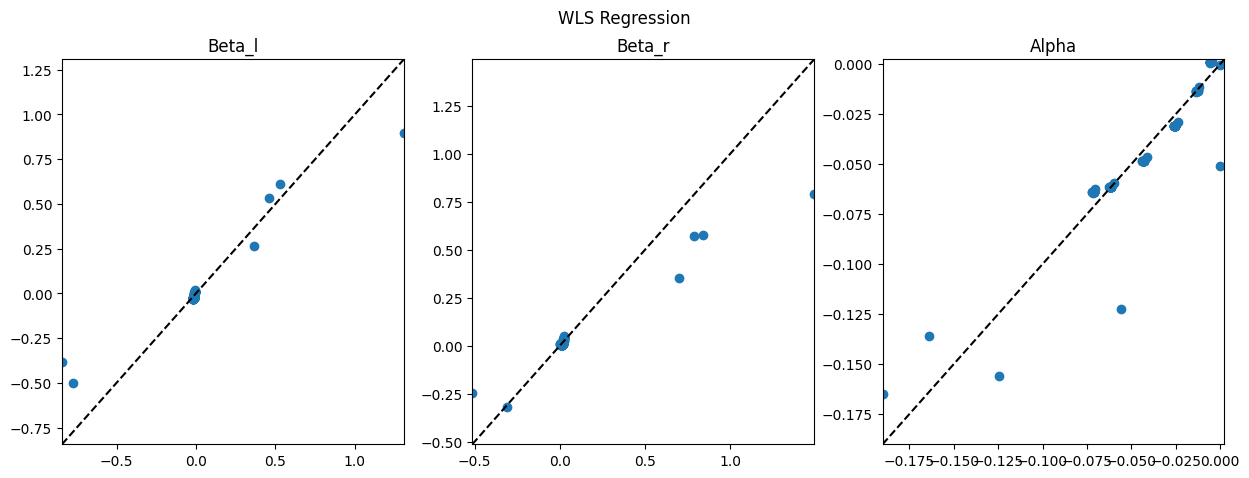

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("WLS Regression")
# fig.suptitle('Horizontally stacked subplots')
# Beta_l
y_min = min(Y[...,0].min(),y_hat[...,0].min())
y_max = max(Y[...,0].max(),y_hat[...,0].max())
ax[0].set_title("Beta_l")
ax[0].set_xlim(y_min,y_max)
ax[0].set_ylim(y_min,y_max)
ax[0].scatter(Y[...,0],y_hat[...,0])
ax[0].plot([y_min,y_max],[y_min,y_max], "--", color='black')
# Beta_r
y_min = min(Y[...,1].min(),y_hat[...,1].min())
y_max = max(Y[...,1].max(),y_hat[...,1].max())
ax[1].set_title("Beta_r")
ax[1].set_xlim(y_min,y_max)
ax[1].set_ylim(y_min,y_max)
ax[1].scatter(Y[...,1],y_hat[...,1])
ax[1].plot([y_min,y_max],[y_min,y_max], "--", color='black')
# Alpha
y_min = min(Y[...,2].min(),y_hat[...,2].min())
y_max = max(Y[...,2].max(),y_hat[...,2].max())
ax[2].set_title("Alpha")
ax[2].set_xlim(y_min,y_max)
ax[2].set_ylim(y_min,y_max)
ax[2].scatter(Y[...,2],y_hat[...,2])
ax[2].plot([y_min,y_max],[y_min,y_max], "--", color='black')
plt.show()

In [42]:
r2_score(Y, y_hat), r2_score(Y, y_hat_ols)

(0.8594634091406733, 0.9261266030505317)

In [43]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Extract coefficients from WLS estimation
theta_0_l, theta_1_l, theta_2_l = theta_hat_wls[:, 0]  # Coefficients for beta_l
theta_0_r, theta_1_r, theta_2_r = theta_hat_wls[:, 1]  # Coefficients for beta_r
theta_0_alpha, theta_1_alpha, theta_2_alpha = theta_hat_wls[:, 2]  # Coefficients for alpha

# Create a grid of values for omega_l and omega_r
omega_l_grid, omega_r_grid = np.meshgrid(np.linspace(omega_l.min(), omega_l.max(), 100),
                                         np.linspace(omega_r.min(), omega_r.max(), 100))

# Calculate the corresponding beta_l, beta_r, and alpha values on the grid
beta_l_grid = theta_0_l + theta_1_l * omega_l_grid + theta_2_l * omega_r_grid
beta_r_grid = theta_0_r + theta_1_r * omega_l_grid + theta_2_r * omega_r_grid
alpha_grid = theta_0_alpha + theta_1_alpha * omega_l_grid + theta_2_alpha * omega_r_grid


In [47]:
fig = plt.figure(figsize=(18, 6))

# Beta_l surface
ax = fig.add_subplot(131, projection='3d')
ax.plot_surface(omega_l_grid, omega_r_grid, beta_l_grid, cmap=cm.viridis, alpha=0.7)
ax.scatter(omega_l, omega_r, beta_l, color='red')  # Original data points
ax.set_title('Beta_l vs Wheel_l and Wheel_r')
ax.set_xlabel('Wheel_l')
ax.set_ylabel('Wheel_r')
ax.set_zlabel('Beta_l')

# Beta_r surface
ax = fig.add_subplot(132, projection='3d')
ax.plot_surface(omega_l_grid, omega_r_grid, beta_r_grid, cmap=cm.viridis, alpha=0.7)
ax.scatter(omega_l, omega_r, beta_r, color='red')  # Original data points
ax.set_title('Beta_r vs Wheel_l and Wheel_r')
ax.set_xlabel('Wheel_l')
ax.set_ylabel('Wheel_r')
ax.set_zlabel('Beta_r')

# Alpha surface
ax = fig.add_subplot(133, projection='3d')
ax.plot_surface(omega_l_grid, omega_r_grid, alpha_grid, cmap=cm.viridis, alpha=0.7)
ax.scatter(omega_l, omega_r, alpha, color='red')  # Original data points
ax.set_title('Alpha vs Wheel_l and Wheel_r')
ax.set_xlabel('Wheel_l')
ax.set_ylabel('Wheel_r')
ax.set_zlabel('Alpha')

plt.show()
